In [1]:
from astropy.io import fits
import os,glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from astropy.stats import sigma_clipped_stats

cwd = os.getcwd()

In [9]:
import pyaxe
pyaxe.__version__


'0.1.dev29+gf57de55.d20200106'

In [2]:
def calculate_median(FILES,ID,WMIN,WMAX,DW):
    out = {}
    # make common wavelength grids [WMIN,WMAX]
    WGRID = np.arange(WMIN,WMAX+DW,step=DW)
    for ss,s in enumerate(FILES):
        # for each image, make interp1d to common grids of an object ID
        d1 = fits.open(s)["BEAM_%dA" % (ID)].data
        w = d1["LAMBDA"]
        f = d1["FLUX"]
        mod_f = interp1d(w,f,kind='linear',bounds_error=False,fill_value=np.nan)
        fmod = mod_f(WGRID)
        # store output
        out[ss] = fmod
    
    dataframe = pd.DataFrame(out)
    x2 = []
    for i in np.arange(0,len(dataframe),step=1):
        # for each wavelength grid, calculate median with sigma clipping
        x = dataframe.iloc[i]
        mean,median,stddev = sigma_clipped_stats(x,sigma=3.,maxiters=5,cenfunc='median')
        x2.append(median)
    # store output
    dataframe['MEDIAN'] = x2
    return WGRID,dataframe

In [3]:
FILES = glob.glob('OUTPUT/*2_opt.SPC.fits')
FILES2 = glob.glob('OUTPUT/*2.SPC.fits')


In [4]:
ID = 74
WMIN = 11500.
WMAX = 16000.
DW = 50.


In [5]:
wgrid,dataframe = calculate_median(FILES,ID,WMIN,WMAX,DW)
wgrid2,dataframe2 = calculate_median(FILES2,ID,WMIN,WMAX,DW)

In [6]:
STANDFILE = 'gd153_mod_010.fits'


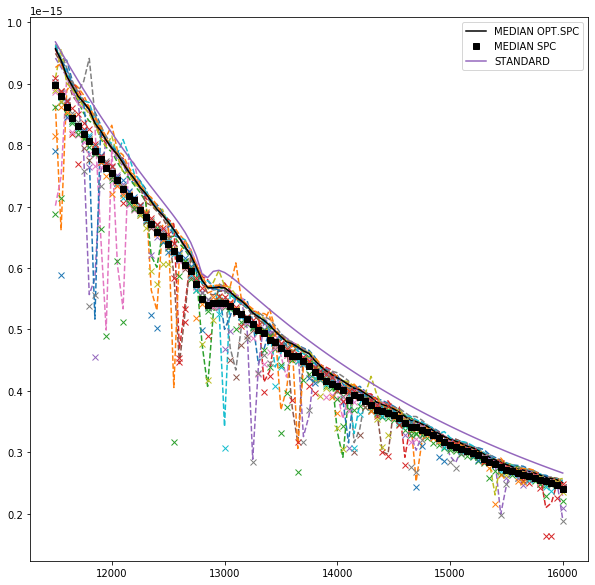

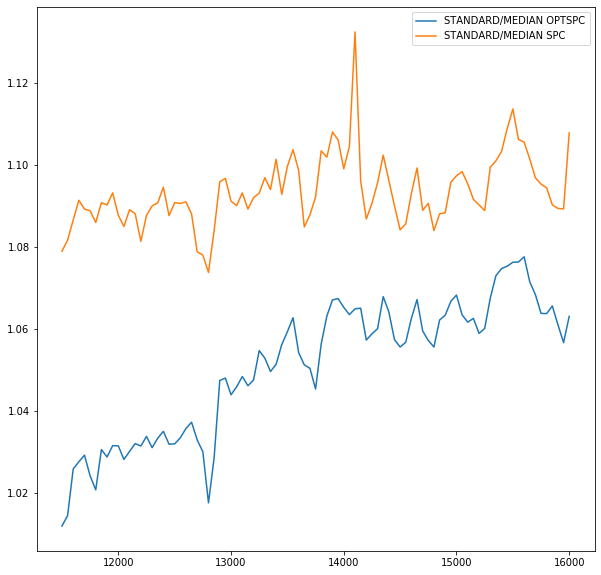

In [7]:
plt.figure(figsize=(10,10))
for i in dataframe.columns:
    if i=='MEDIAN':
        plt.plot(wgrid,dataframe[i],'k-',label='MEDIAN OPT.SPC')
    else:
        plt.plot(wgrid,dataframe[i],'--')
        
for i in dataframe2.columns:
    if i=='MEDIAN':
        plt.plot(wgrid2,dataframe2[i],'ks',label='MEDIAN SPC')
    else:
        plt.plot(wgrid2,dataframe2[i],'x')
        
x = fits.open(STANDFILE)
x2 = pd.DataFrame(x[1].data)
w,f = x2['WAVELENGTH'],x2['FLUX']
mod = interp1d(w.values,f.values,kind='linear',bounds_error=False,fill_value=np.nan)
f2 = mod(wgrid)
plt.plot(wgrid,f2,label='STANDARD')

plt.legend()
    
plt.figure(figsize=(10,10))
plt.plot(wgrid,f2/dataframe['MEDIAN'],label='STANDARD/MEDIAN OPTSPC')
plt.plot(wgrid,f2/dataframe2['MEDIAN'],label='STANDARD/MEDIAN SPC')
plt.legend()